# MERFISH whole brain spatial transcriptomics (part 2b)

We can continue to explore our examples looking at the expression of canonical neurotransmitter transporter genes and gene Tac2 over the whole brain.

You need to be connected to the internet to run this notebook and that you have downloaded the example data via the getting started notebook.

In [1]:
import os
import pandas as pd
import numpy as np
import anndata
import time
import json
import matplotlib.pyplot as plt
import requests

%matplotlib inline

The prerequisite for running this notebook is that the data have been downloaded to local directory maintaining the organization from the manifest.json. **Change the download_base variable to where you have downloaded the data in your system.**

In [2]:
version = '20230830'
download_base = '../../abc_download_root'

use_local_cache = False
manifest_path = 'releases/%s/manifest.json' % version

if not use_local_cache :
    url = 'https://allen-brain-cell-atlas.s3-us-west-2.amazonaws.com/' + manifest_path
    manifest = json.loads(requests.get(url).text)
else :
    file = os.path.join(download_base,manifest_path)
    with open(file,'rb') as f:
        manifest = json.load(f)
    
metadata = manifest['file_listing']['MERFISH-C57BL6J-638850']['metadata']

In [3]:
view_directory = os.path.join( download_base, 
                               manifest['directory_listing']['MERFISH-C57BL6J-638850']['directories']['metadata']['relative_path'], 
                              'views')
cache_views = False
if cache_views :
    os.makedirs( view_directory, exist_ok=True )

Read in the expanded cell metadata table we created in part 1.

In [4]:
rpath = metadata['cell_metadata_with_cluster_annotation']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath )
cell = pd.read_csv(file,dtype={"cell_label":str,"neurotransmitter":str})
cell.set_index('cell_label',inplace=True)

In [5]:
cell.columns

Index(['brain_section_label', 'cluster_alias', 'average_correlation_score',
       'feature_matrix_label', 'donor_label', 'donor_genotype', 'donor_sex',
       'x', 'y', 'z', 'neurotransmitter', 'class', 'subclass', 'supertype',
       'cluster', 'neurotransmitter_color', 'class_color', 'subclass_color',
       'supertype_color', 'cluster_color'],
      dtype='object')

Read in the gene expression dataframe we created in part 2a.

In [6]:
rpath = metadata['example_genes_all_cells_expression']['files']['csv']['relative_path']
file = os.path.join( download_base, rpath )
exp = pd.read_csv(file,dtype={"cell_label":str})
exp.set_index('cell_label',inplace=True)

We define a helper functions *aggregate_by_metadata* to compute the average expression for a given catergory.

In [7]:
def aggregate_by_metadata( df, gnames, value, sort=False ) :
    grouped = df.groupby(value)[gnames].mean()
    if sort :
        grouped = grouped.sort_values(by=gnames[0],ascending=False)
    return grouped

### Expression of canonical neurotransmitter transporter genes

During analysis, clusters were assigned neurotransmitter identities based on the expression of of canonical neurotransmitter transporter genes. In this example, we create a dataframe comprising of expression of the 9 solute carrier family genes for all the cells in the dataset.  We then group the cells by the assigned neurotransmitter class and compute the mean expression for each group and visualized as a colorized table.

The results are similar that in part 1. Using data from the whole brain, gene Slc17a7 is now most enriched in glutamatergic assigned cells. Gene Slc17a6 is most enriched in noradrenergic, then cholinergic types. Genes Slc6a5, Slc6a3 and Slc6a4 shows high specificity to glycinergic, dopaminergic, serotonergic respectively.

In [8]:
def plot_heatmap( df, fig_width = 8, fig_height = 4, cmap=plt.cm.magma_r, vmin=0, vmax=5) :

    arr = df.to_numpy()

    fig, ax = plt.subplots()
    fig.set_size_inches(fig_width,fig_height)

    res = ax.imshow(arr, cmap = cmap, aspect='auto', vmin=vmin, vmax=vmax)
    xlabs = df.columns.values
    ylabs = df.index.values

    ax.set_xticks(range(len(xlabs)))
    ax.set_xticklabels( xlabs )

    ax.set_yticks(range(len(ylabs)))
    res = ax.set_yticklabels( ylabs )

In [9]:
ntgenes = ['Slc17a7','Slc17a6','Slc17a8','Slc32a1','Slc6a5','Slc6a3','Slc6a4']
filtered = exp[ntgenes]
joined = cell.join( filtered )

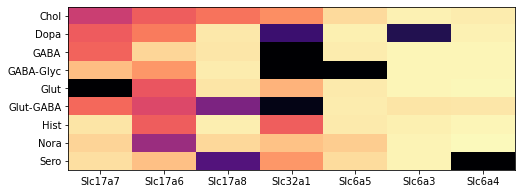

In [10]:
agg = aggregate_by_metadata( joined, ntgenes, 'neurotransmitter' )
agg = agg[ntgenes]
plot_heatmap(agg,8,3,vmax=4)

Grouping expression by dissection region of interest shows that each of these genes have distinct spatial patterns. The MERFISH data allows us to visualize these patterns in anatomical context.

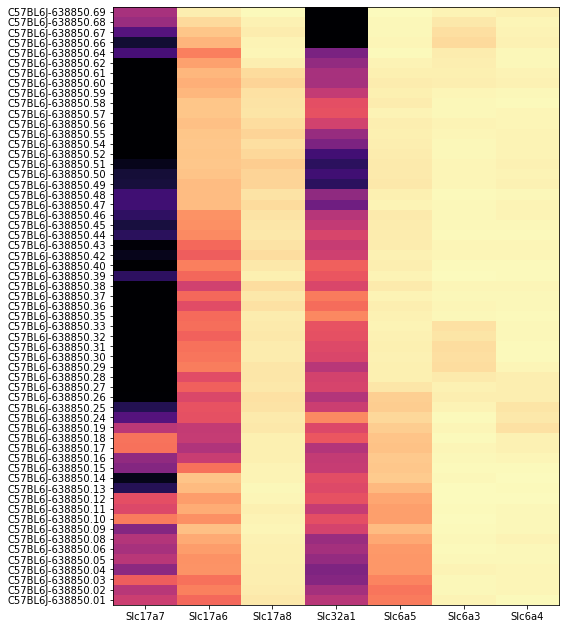

In [11]:
agg = aggregate_by_metadata( joined, ntgenes, 'brain_section_label' )
agg = agg.loc[list(reversed(list(agg.index)))]
plot_heatmap(agg,8,11,vmax=3)

We define a small helper function *plot sections* to visualize the cells for a specified set of brain sections either by colorized metadata or gene expression.

In [12]:
def plot_sections( df, feature, blist, cmap=None, fig_width = 20, fig_height = 5) :
    
    fig, ax = plt.subplots(1,len(blist))
    fig.set_size_inches(fig_width, fig_height)
    
    for idx,bsl in enumerate(blist) :
        
        filtered = df[df['brain_section_label'] == bsl]
        xx = filtered['x']
        yy = filtered['y']
        vv = filtered[feature]
        
        if cmap is not None :
            ax[idx].scatter(xx,yy,s=1.0,c=vv,marker='.',cmap=cmap)
        else :
            ax[idx].scatter(xx,yy,s=1.0,color=vv,marker=".")
            
        ax[idx].axis('equal')
        ax[idx].set_xlim(0,11)
        ax[idx].set_ylim(11,0)
        ax[idx].set_xticks([])
        ax[idx].set_yticks([])
        
        ax[idx].set_title("%s" % (bsl) )
        
    plt.subplots_adjust(wspace=0.01, hspace=0.01)
    return fig, ax
    

We will use the aggregate by brain section table above to pick a four sections of interest and plot cells in those sections by neurotransmitter type and by each of the transporter genes.

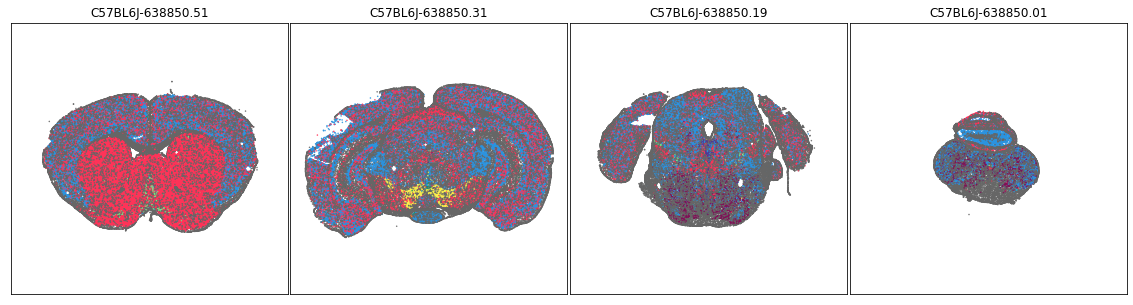

In [13]:
blist = ['C57BL6J-638850.51','C57BL6J-638850.31','C57BL6J-638850.19','C57BL6J-638850.01']
fig, ax = plot_sections( joined, 'neurotransmitter_color', blist, cmap=None)

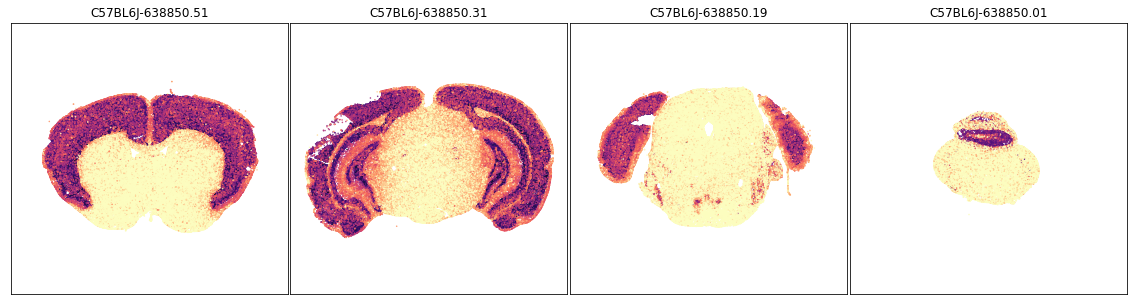

In [14]:
fig, ax = plot_sections( joined, 'Slc17a7', blist, cmap=plt.cm.magma_r)

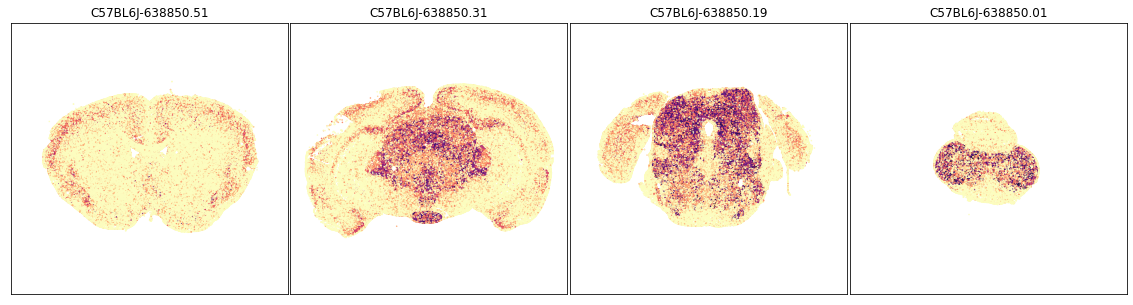

In [15]:
fig, ax = plot_sections( joined, 'Slc17a6', blist, cmap=plt.cm.magma_r)

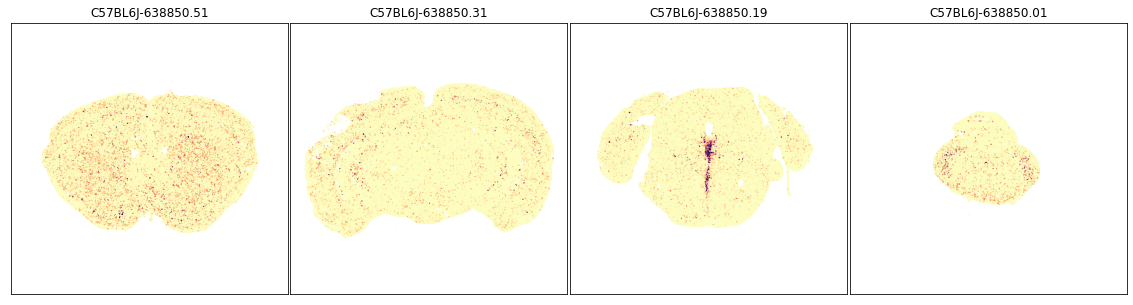

In [16]:
fig, ax = plot_sections( joined, 'Slc17a8', blist, cmap=plt.cm.magma_r)

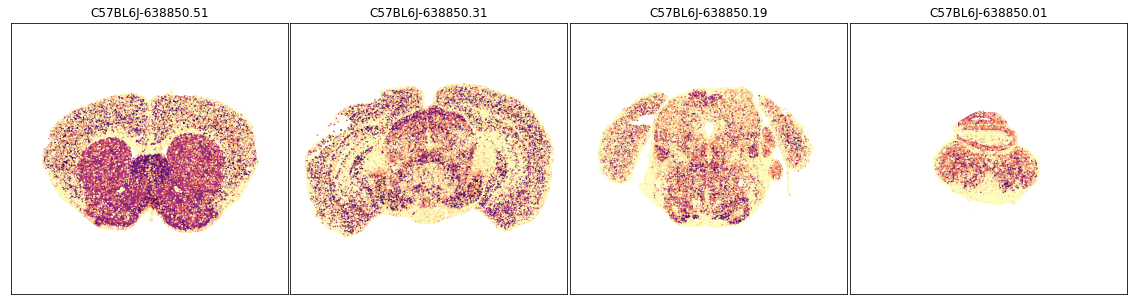

In [17]:
fig, ax = plot_sections( joined, 'Slc32a1', blist, cmap=plt.cm.magma_r)

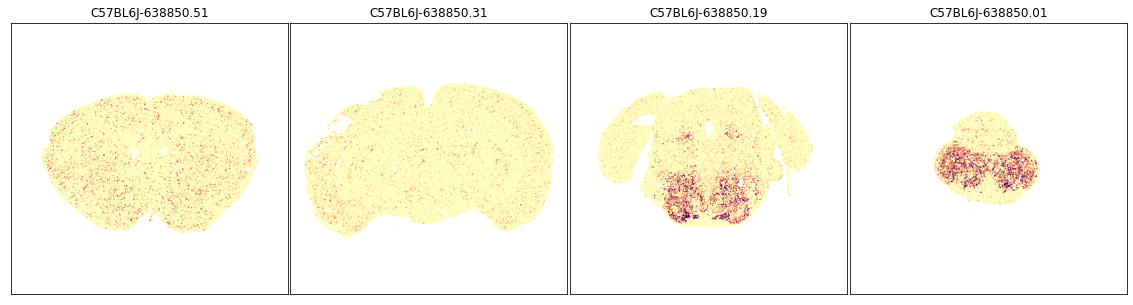

In [18]:
fig, ax = plot_sections( joined, 'Slc6a5', blist, cmap=plt.cm.magma_r)

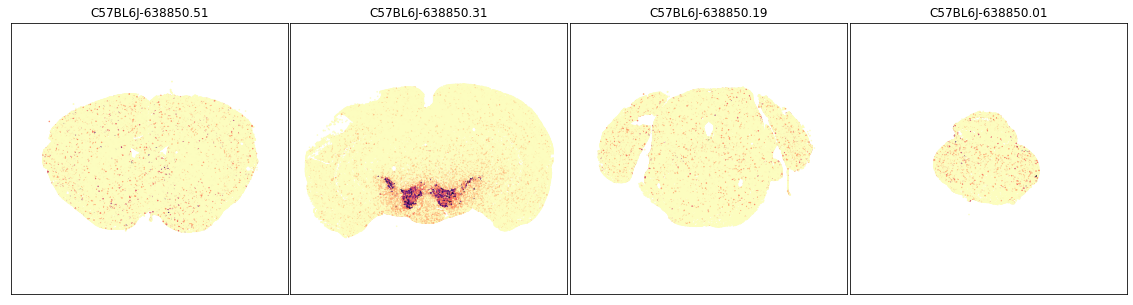

In [19]:
fig, ax = plot_sections( joined, 'Slc6a3', blist, cmap=plt.cm.magma_r)

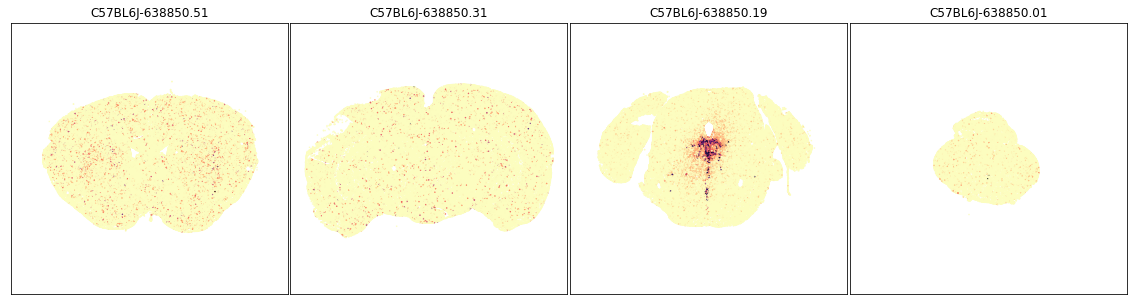

In [20]:
fig, ax = plot_sections( joined, 'Slc6a4', blist, cmap=plt.cm.magma_r)

### Expression of Tachykinin 2 (Tac2) in the whole brain

In mice, the tachykinin 2 (Tac2) gene encodes neuropeptide called neurokinin B (NkB). Tac2 is produced by neurons in specific regions of the brain know to be invovled in emotion and social behavior. Based on [ISH data](https://mouse.brain-map.org/experiment/siv?id=77279001&imageId=77284584&initImage=ish&coordSystem=pixel&x=5384.5&y=3832.5&z=3) from the Allen Mouse Brain Atlas, Tac 2 is sparsely expressed in the mouse isocortex and densely enriched is specific subcortical regions such the medial habenula (MH), the amygdala and hypothalamus.

In this example, we create a dataframe comprising expression values of Tac2 for all cells across the whole brain. As with the single brain section example, grouping expression by neurotransmitter show that Tac2 gene is enriched in cholinergic cell types. With the rest of brain included, we can observe that Tac2 is also enriched in Glut-GABA cell types as well.

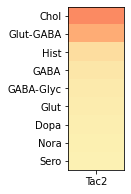

In [21]:
exgenes = ['Tac2']
filtered = exp[exgenes]
joined = cell.join( filtered )
agg = aggregate_by_metadata( joined, exgenes, 'neurotransmitter', True )
plot_heatmap(agg,1,3)

Grouping by class, shows that Tac2 is enriched in class "16 MH-LH Glut" with cells restricted to the medial (MH) and lateral (LH) habenula and a mixture of glutamatergic and cholinergic type and "06 CTX-CGE GABA" GABAergic cells originating from the caudal ganglionic eminence (CGE).

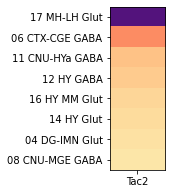

In [22]:
agg = aggregate_by_metadata( joined, exgenes, 'class', True ).head(8)
class_list = agg.index[0:2]
plot_heatmap(agg,1,3)

At the next level, grouping by subclass reveals enrichment is highly anatomically localized cell types such as the medial habenula (MH), bed nuclei of the stria terminalis (BST), spinal nucleus of the trigeminal (SPVC), main olfactory blub (MOB), central amygdalar nucleus (CEA) and arcuate hypothalamic nucleus (ARH).

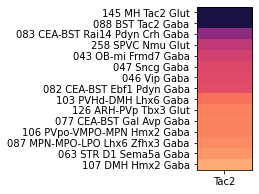

In [23]:
agg = aggregate_by_metadata( joined, exgenes, 'subclass', True ).head(15)
subclass_list = agg.index[0:10]
plot_heatmap(agg,1,3)

The MERFISH data allows us to visualize these spatial pattern in anatomical context. We can aggregate Tac2 expression by brain section so that we can find 4 sections where the enriched expression is located. We then visualize cells in those section by Tac2 expression, neurotransmitter identity, cell type classes and subclasses. 

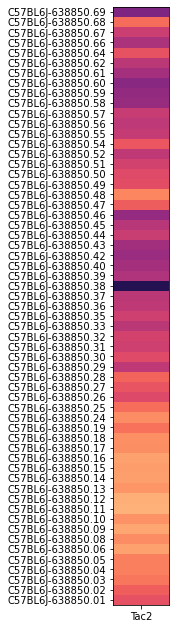

In [24]:
agg = aggregate_by_metadata( joined, exgenes, 'brain_section_label', False )
agg = agg.loc[list(reversed(list(agg.index)))]
plot_heatmap(agg,1,11,vmax=0.4)

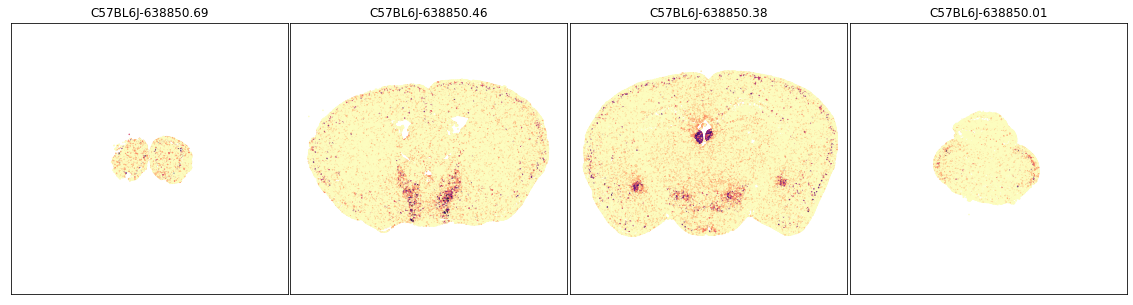

In [25]:
blist = ['C57BL6J-638850.69','C57BL6J-638850.46','C57BL6J-638850.38','C57BL6J-638850.01']
fig, ax = plot_sections( joined, 'Tac2', blist, cmap=plt.cm.magma_r)

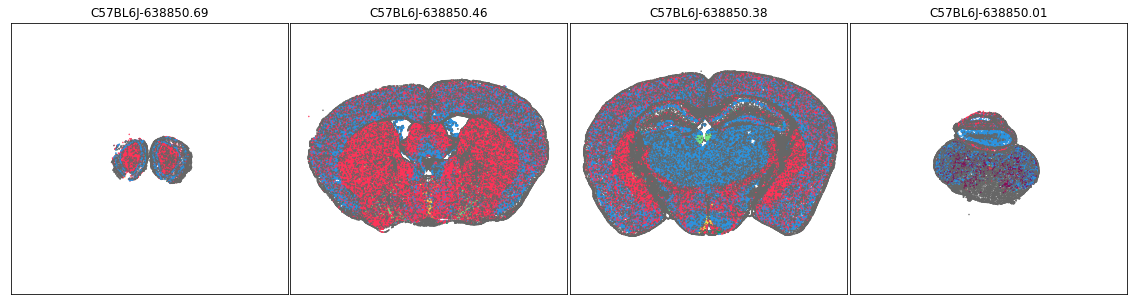

In [26]:
fig, ax = plot_sections( joined, 'neurotransmitter_color', blist, cmap=None)

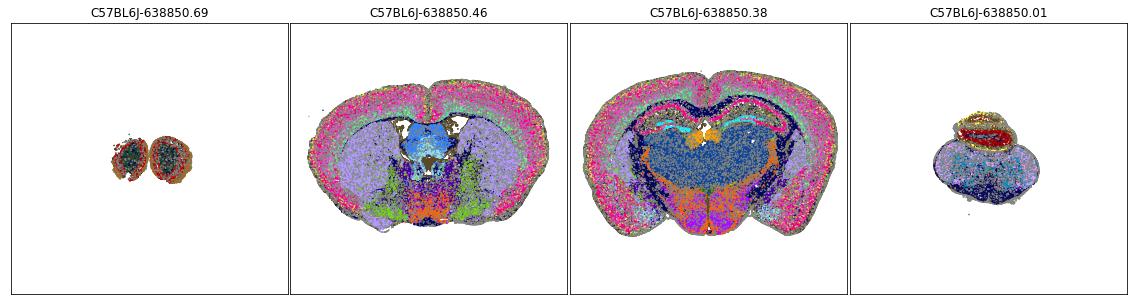

In [27]:
fig, ax = plot_sections( joined, 'class_color', blist, cmap=None)

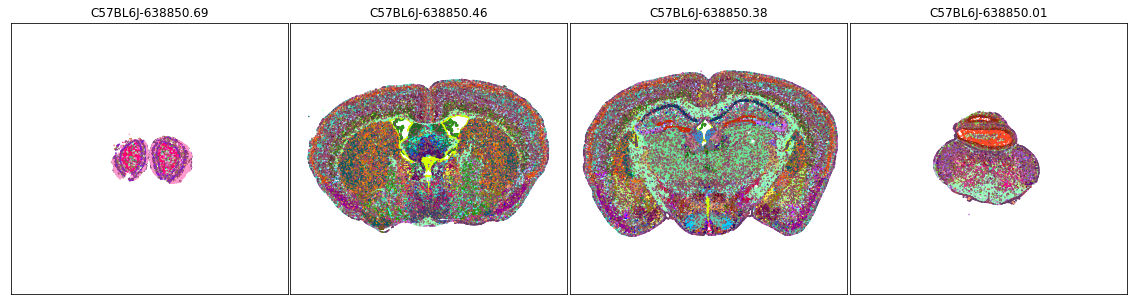

In [28]:
fig, ax = plot_sections( joined, 'subclass_color', blist, cmap=None)

We can use the Tac2 aggregate by subclass table above and pick out the top 10 most enriched subclasses and plot only them on the same set of brain sections and observed that this set of subclasses is able recapitulate the expression pattern of Tac2.

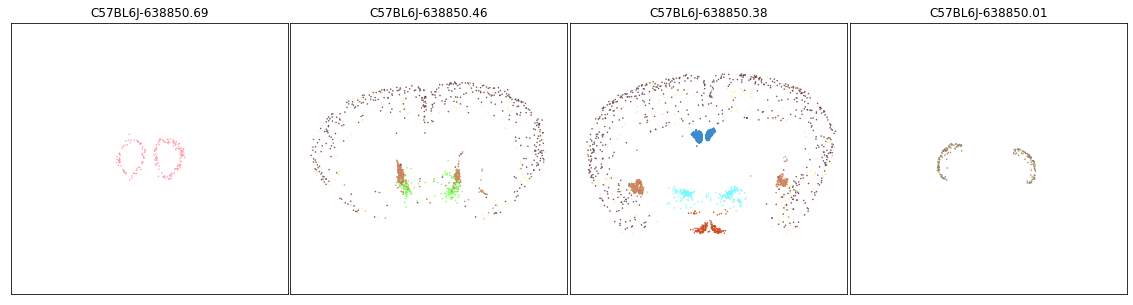

In [29]:
pred = [x in subclass_list for x in joined['subclass']]
filtered = joined[pred]
fig, ax = plot_sections( filtered, 'subclass_color', blist, cmap=None)

In [30]:
subclass_list

Index(['145 MH Tac2 Glut', '088 BST Tac2 Gaba',
       '083 CEA-BST Rai14 Pdyn Crh Gaba', '258 SPVC Nmu Glut',
       '043 OB-mi Frmd7 Gaba', '047 Sncg Gaba', '046 Vip Gaba',
       '082 CEA-BST Ebf1 Pdyn Gaba', '103 PVHd-DMH Lhx6 Gaba',
       '126 ARH-PVp Tbx3 Glut'],
      dtype='object', name='subclass')